# Propensity modeling for Santander Customer Transaction


## Importing libraries



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [41]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import missingno as msno
import numpy as np
import time
import gc

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from imblearn import keras
from imblearn.keras import BalancedBatchGenerator
from imblearn.over_sampling import RandomOverSampler

## Loading and optimizing data

In [3]:
def reduce_mem_usage(df, verbose=True):
  """ iterate through all the columns of a dataframe and modify the data type
      to reduce memory usage.        
  """    
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
  
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
                  
  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

In [4]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/Santander Customer Transaction Prediction/data/train.csv')
df.drop(['ID_code'], axis=1, inplace=True)
df = reduce_mem_usage(df, verbose=True)

Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 76.48 MB
Decreased by 75.1%


## Data Sampling

In [7]:
df_x = df.drop(['target'], axis=1)
df_y = df[['target']]
features = list(df_x.columns.values)

X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, shuffle=False, train_size=0.8)

In [21]:
Y_train.target = Y_train.target.astype(np.float32)
Y_test.target = Y_test.target.astype(np.float32)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [9]:
def evaluate(y_true, y_predicted):
  print("area under the ROC curve:", roc_auc_score(y_true, y_predicted))
  print(classification_report(y_true, y_predicted))
  print(confusion_matrix(y_true, y_predicted))

  auc = roc_auc_score(y_true, y_predicted)
  fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=1)

  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], '--')
  plt.xlim(0, 1.01)
  plt.ylim(0, 1.01)
  plt.title('AUC: {}'.format(round(auc, 2)))

In [10]:
def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [26]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train_st.shape[1],), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['acc'])

In [30]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]

In [31]:
callback_history = model.fit(X_train_st, Y_train, epochs=100, batch_size=256, validation_split = 0.3, callbacks=callbacks)

Epoch 1/100
438/438 [==============================] - 2s 4ms/step - loss: 0.1036 - acc: 0.9618 - val_loss: 0.4036 - val_acc: 0.8922
Epoch 2/100
438/438 [==============================] - 2s 4ms/step - loss: 0.1033 - acc: 0.9623 - val_loss: 0.4025 - val_acc: 0.8950
Epoch 3/100
438/438 [==============================] - 2s 4ms/step - loss: 0.1028 - acc: 0.9614 - val_loss: 0.4228 - val_acc: 0.8947
Epoch 4/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0998 - acc: 0.9634 - val_loss: 0.4164 - val_acc: 0.8948
Epoch 5/100
438/438 [==============================] - 2s 4ms/step - loss: 0.1004 - acc: 0.9636 - val_loss: 0.4126 - val_acc: 0.8925
Epoch 6/100
438/438 [==============================] - 2s 4ms/step - loss: 0.1013 - acc: 0.9628 - val_loss: 0.4207 - val_acc: 0.8930
Epoch 7/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0986 - acc: 0.9637 - val_loss: 0.4248 - val_acc: 0.8953
Epoch 8/100
438/438 [==============================] - 2s 4ms/step - 

In [32]:
yhat_classes = model.predict_classes(X_test_st, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [36]:
yhat_classes = yhat_classes.reshape(40000)

area under the ROC curve: 0.6092946624016572
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     35951
         1.0       0.43      0.26      0.32      4049

    accuracy                           0.89     40000
   macro avg       0.68      0.61      0.63     40000
weighted avg       0.87      0.89      0.88     40000

[[34602  1349]
 [ 3012  1037]]


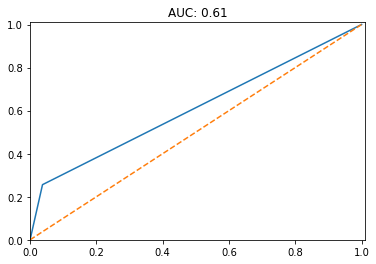

In [45]:
evaluate(Y_test, yhat_classes)